In [1]:
import gtfstk as gt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import folium
import seaborn as sns
%matplotlib inline

In [2]:
grid=gpd.read_file(r"N:\Planning - New File Structure\GIS\Data\Political\Boundaries\Ada_Canyon_Fishnet_WGS84_200m.shp")

In [3]:
# Read in data for employer locations
employers=pd.read_excel(r"P:\Projects\Fare\Employer Programs\EPP_Businesses.xlsx")

In [5]:
# Read in GTFS feed
feed=gt.read_gtfs(r"N:\Planning - New File Structure\GIS\Data\OFFICIAL CURRENT\GTFS\VRT_Transit1.zip",dist_units='mi')

In [6]:
# Get needed data from stop_times, trips, and routes files
stop_stats=gt.stops.compute_stop_stats(feed,dates=['20190705','20190706'])
stop_stats['score']=''
stop_stats['score']=stop_stats['num_routes']*stop_stats['num_trips']

In [8]:
# Get latitute and longitude back.
df=stop_stats.merge(feed.stops,how='left')
df['Coordinates']=list(zip(df.stop_lon,df.stop_lat))
df['Coordinates']=df['Coordinates'].apply(Point)
df=gpd.GeoDataFrame(df,geometry='Coordinates')
df=df[['stop_id','num_trips','num_routes','score','Coordinates']]
df.head()

stop_id  num_trips  num_routes  score  \
0   01010603       43.0         1.0   43.0   
1   01010003      100.0         2.0  200.0   
2   01010004       14.0         1.0   14.0   
3   01010005       14.0         1.0   14.0   
4   01010006       14.0         1.0   14.0   

                                    Coordinates  
0  POINT (-116.2038255162906 43.62044639628175)  
1  POINT (-116.2788805790953 43.66947350576436)  
2  POINT (-116.2793061968683 43.66985359608981)  
3  POINT (-116.2790807374933 43.67148091960437)  
4  POINT (-116.2793234323342 43.67171802620658)

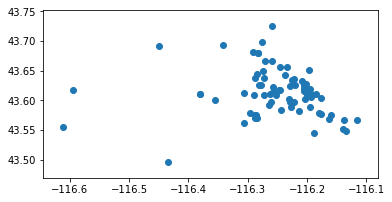

In [4]:
# Convert to geodataframe
employers['Coordinates']=list(zip(employers.Longitude,employers.Latitude))
employers['Coordinates']=employers['Coordinates'].apply(Point)
employers=employers.dropna(axis=0,subset=['Latitude','Longitude'])
employers=gpd.GeoDataFrame(employers,geometry='Coordinates')
employers.plot()

In [9]:
# Buffer employer locations by 1/2 mile and get all stops within
employers['geometry']=employers.Coordinates.buffer(.009051)
employers=gpd.GeoDataFrame(employers,geometry='geometry')
employers=gpd.sjoin(employers,df,how='right')

In [25]:
# Add all the stop scores within each employers buffer zone to get a "location score"
employers.head()

index_left     Employer Campus  Employees  \
index_right                                              
993                 0.0  Boise State    NaN     3304.0   
465                 0.0  Boise State    NaN     3304.0   
992                 0.0  Boise State    NaN     3304.0   
464                 0.0  Boise State    NaN     3304.0   
193                 0.0  Boise State    NaN     3304.0   

             Annual pass boardings Staff  Annual Pass Boardings Students  \
index_right                                                                
993                                  NaN                             NaN   
465                                  NaN                             NaN   
992                                  NaN                             NaN   
464                                  NaN                             NaN   
193                                  NaN                             NaN   

              Latitude   Longitude                    Coordinates_x   stop_id  \
index_right                                                                     
993          43.602699 -116.203649  POINT (-116.2036491 43.6026991)  01010904   
465          43.602699 -116.203649  POINT (-116.2036491 43.6026991)  01010904   
992          43.602699 -116.203649  POINT (-116.2036491 43.6026991)  01010903   
464          43.602699 -116.203649  POINT (-116.2036491 43.6026991)  01010903   
193          43.602699 -116.203649  POINT (-116.2036491 43.6026991)  01010498   

             num_trips  num_routes  score  \
index_right                                 
993               11.0         1.0   11.0   
465               19.0         1.0   19.0   
992               11.0         1.0   11.0   
464               18.0         1.0   18.0   
193                6.0         2.0   12.0   

                                            Coordinates_y  
index_right                                                
993           POINT (-116.2048772273564 43.5978555313956)  
465           POINT (-116.2048772273564 43.5978555313956)  
992          POINT (-116.2050460138709 43.59806626576472)  
464          POINT (-116.2050460138709 43.59806626576472)  
193          POINT (-116.1962936068182 43.59832154327328)

In [19]:
# Assign each employer a color by quartile (best 25% dark blue, worst 25% dark red)
df1['color']=pd.qcut(df1['locationScore'],10,labels=['#fff100',
                                                       '#ff8c00',
                                                       '#e81123',
                                                       '#ec008c',
                                                       '#68217a',
                                                       '#00188f',
                                                       '#00bcf2',
                                                       '#00b294',
                                                       '#009e49',
                                                      '#bad80a'])
df1

Employer  locationScore   Latitude   Longitude    color
0             Ada County           37.0  43.567089 -116.137664  #fff100
1  Boise School District          184.0  43.602933 -116.176183  #ec008c
2                    DEQ          918.0  43.617395 -116.247332  #00bcf2
3             St. Luke's         1407.0  43.612756 -116.194560  #bad80a

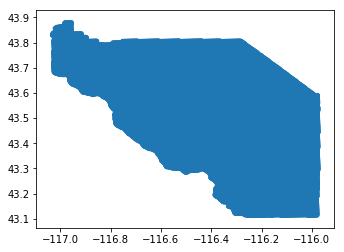

In [10]:
# Buffer employer locations by 1/2 mile and get all stops within
grid['geometry']=grid.geometry.buffer(.009051)
grid=gpd.GeoDataFrame(grid,geometry='geometry')
grid.plot()

In [11]:
grid=gpd.sjoin(grid,df,how='left')
grid.dropna(subset=['score'],inplace=True)

In [12]:
grid.head()

OBJECTID  Id                                           geometry  \
55819     55820   0  POLYGON ((-116.5677782512365 43.5376932886421,...   
55820     55821   0  POLYGON ((-116.5653052890993 43.53774905351018...   
55821     55822   0  POLYGON ((-116.562832319873 43.53780476493579,...   
55822     55823   0  POLYGON ((-116.5603593435645 43.53786042291848...   
56146     56147   0  POLYGON ((-116.5703279625872 43.53943651517236...   

       index_right   stop_id  num_trips  num_routes  score  
55819        678.0  14050016       22.0         1.0   22.0  
55820        678.0  14050016       22.0         1.0   22.0  
55821        678.0  14050016       22.0         1.0   22.0  
55822        678.0  14050016       22.0         1.0   22.0  
56146        678.0  14050016       22.0         1.0   22.0

In [20]:
# Make a nifty map!
m=folium.Map(location=[43.6103678,-116.3920567])
for index, row in df1.iterrows():
    folium.Marker([row['Latitude'], row['Longitude']],
                        
                        popup=row['Employer'],
                        icon=folium.Icon(color=row['color']),
                       ).add_to(m)
m

c:\users\bparker\appdata\local\conda\conda\envs\py3\lib\site-packages\pysal\__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysalnext` package. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


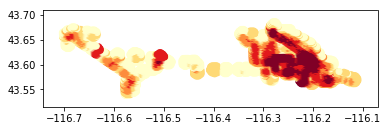

In [13]:
grid2=grid.groupby(['OBJECTID'])['score'].sum().reset_index(name='locationScore')
grid=grid.merge(grid2)
grid=gpd.GeoDataFrame(grid,geometry='geometry')
grid=grid.dissolve(by='OBJECTID',aggfunc='first')
grid.reset_index(inplace=True)
grid['point']=grid['geometry'].centroid
grid=gpd.GeoDataFrame(grid,geometry='point')
grid['Longitude']=grid.point.x
grid['Latitude']=grid.point.y
grid.plot(column='locationScore',scheme='quantiles',cmap='YlOrRd')

In [15]:
grid['color']=pd.qcut(grid['locationScore'],10,labels=['#FF0080',
                                                       '#BF3F80',
                                                       '#7F7F80',
                                                       '#3FBF80',
                                                       '#00FF80',
                                                       '#00CC99',
                                                       '#0099B2',
                                                       '#0066CC',
                                                       '#0033E5',
                                                      '#0000FF'])


In [16]:
grid['geometry']=[Point(xy) for xy in zip(grid.Longitude, grid.Latitude)]
grid=gpd.GeoDataFrame(grid, geometry='geometry')
# grid.to_file(r"N:\Planning - New File Structure\GIS\Data\Accessibility\Network_10zones.shp")
# hull=grid.groupby('color').apply(lambda x: x.convex_hull)
# for index, row in hull.iterrows():
#     hull[row]=row['geometry'].convex_hull
# hull=gpd.GeoDataFrame(hull, geometry='geometry')
# hull.to_file("P:\Projects\Fare\Employer Programs\ScoreMapGrid.shp")
# hull.head()

In [17]:
# Make a nifty map!
m=folium.Map(location=[43.6103678,-116.3920567])
for index, row in grid.iterrows():
    folium.CircleMarker([row['Latitude'], row['Longitude']],
                        radius=2,
                        color=row['color'],
                        popup=str(row[['locationScore','totalRoutes','totalTrips']]),
                        fill=False
                       ).add_to(m)
m

c:\users\bparker\appdata\local\conda\conda\envs\py3\lib\site-packages\pandas\core\series.py:851: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


In [18]:
# m.save(r"P:\Projects\Fare\Employer Programs\ScoreMapGrid.html")

In [21]:
# m.save(r"P:\Projects\Fare\Employer Programs\ScoreMap.html")

In [22]:
dissolved=gpd.GeoDataFrame(grid.dissolve('color').convex_hull)
dissolved.reset_index(inplace=True)
dissolved.columns=['zone','geometry']
dissolved=gpd.GeoDataFrame(dissolved,geometry='geometry')
dissolved

zone                                           geometry
0  #FF0080  POLYGON ((-116.5621438633712 43.54162521090727...
1  #BF3F80  POLYGON ((-116.5768292512366 43.53769328864208...
2  #7F7F80  POLYGON ((-116.5744328984816 43.53954810489439...
3  #3FBF80  POLYGON ((-116.5671665483446 43.54331320897566...
4  #00FF80  POLYGON ((-116.5747394069034 43.54674430373599...
5  #00CC99  POLYGON ((-116.5697927265835 43.5468557058003,...
6  #0099B2  POLYGON ((-116.5703283601096 43.55944907372899...
7  #0066CC  POLYGON ((-116.2138255452066 43.56151234125289...
8  #0033E5  POLYGON ((-116.2237238421156 43.56132010788422...
9  #0000FF  POLYGON ((-116.2187747058931 43.56141633159638...

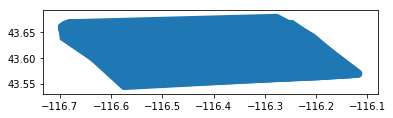

In [23]:
dissolved.plot()

In [24]:
for index, row in dissolved.iterrows():
    row['geometry'].plot()

AttributeError: 'Polygon' object has no attribute 'plot'

In [ ]:
# dissolved.to_file(r"N:\Planning - New File Structure\GIS\Data\Accessibility\Network_10zones.shp")

In [ ]:
# grid.to_file(r"N:\Planning - New File Structure\GIS\Data\Accessibility\Network_10zones_grid.shp")